# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df()

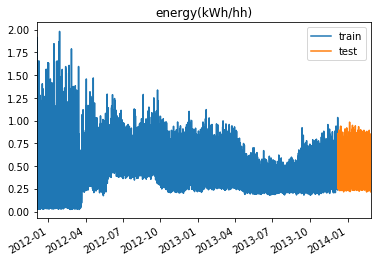

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [9]:
PERCENT_TEST_EXAMPLES = 0.5
# EPOCHS = 5
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'anp-rnn2'
name = 'anp-rnn2' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2


In [10]:
def main(trial, train=True):    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name="anp-rnn", version=trial.number)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(trial.params)
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial):
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])

    # training specific (for this model)
    trial.suggest_uniform("min_std", 0.005, 0.005)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("num_context", 24 * 4, 24 * 4)
    trial.suggest_int("num_extra_target", 24*4, 24*4)
    trial.suggest_int("max_nb_epochs", 10, 10)
    trial.suggest_int("num_workers", 3, 3)
    trial.suggest_int("batch_size", 16, 16)
    trial.suggest_int("num_heads", 8, 8)

    trial.suggest_int("x_dim", 17, 17)
    trial.suggest_int("y_dim", 1, 1)
    trial.suggest_int("vis_i", 670, 670)
    
    trial.suggest_categorical("context_in_target", [True])
    
    return trial

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
    print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


# Default params

In [11]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batch_size': 16,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0,
 'grad_clip': 40,
 'hidden_dim': 128,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002,
 'max_nb_epochs': 10,
 'min_std': 0.005,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2,
 'num_context': 24*4,
 'num_extra_target': 24*4,
 'num_heads': 8,
 'num_workers': 3,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'vis_i': '670',
 'x_dim': 17,
 'y_dim': 1,
 'use_rnn': False,
 'context_in_target': True
}

# Train ANP-RNN

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel    1 M
1                           model._lstm           LSTM  207 K
2                 model._latent_encoder  LatentEncoder   98 K
3    model._latent_encoder._input_layer         Linear   16 K
4        model._latent_encoder._encoder     ModuleList   32 K
..                                  ...            ...    ...
121    model._decoder._decoder.3.linear         Linear  147 K
122       model._decoder._decoder.3.act           ReLU    0  
123   model._decoder._decoder.3.dropout      Dropout2d    0  
124                model._decoder._mean         Linear  385  
125                 model._decoder._std         Linear  385  

[126 rows x 3 columns]


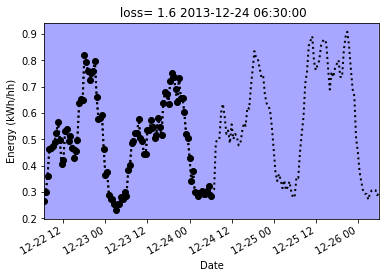

step 0, {'val_loss': '1.5333813428878784', 'val/kl': '0.5012272000312805', 'val/mse': '0.2871371805667877', 'val/std': '0.9575740694999695'}


KeyboardInterrupt: 

In [12]:
name = 'anp-rnn'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': True,
 'use_rnn': True
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# ANP-RNN 2

In [ ]:
name = 'anp-rnn'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'ptmultihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': False,
 'use_rnn': True
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

In [ ]:
# # plot lots of metrics
# loader = model.val_dataloader()[0]
# for i in range(0, len(loader), 10):
#     plot_from_loader(loader, model, i=i)
#     plt.show()

# ANP

In [ ]:
name = 'anp'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'multihead',
 'latent_enc_self_attn_type': 'multihead',
 'use_deterministic_path': True,
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# NP

In [ ]:
name = 'np'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'uniform',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
    'use_deterministic_path': False,
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# Hyperparam

In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


In [ ]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('2d').total_seconds())

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T